### Additional Features from Microstructural Datasets

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Distribution of Order Sizes

Easly et al. studied the frequency of orders by order size and found that transactions with rounded sizes were abnormally frequent. For example, while transaction frequency decreases rapidly as a function of transaction size, rounded transaction sizes like $\{5, 10, 20, 25, 50, 100, 200, \dots \}$ were exceptions. Easley et al. attributed this phenomenon to so-called mouse or GUI traders - human traders who place orders using GUI buttons. In the case of E-mini S&P500, size 10 was 2.9 times more frequent than size 9, size 50 was 10.9 times more frequent than size 49, size 100 was 2.9 times more frequent than size 99, size 200 was 27.2 times more frequent than size 199, size 250 was 32.5 times more frequent than size 249, and size 500 was a whopping 57.1 times more frequent than size 499. This pattern is quite different from that of silicon traders who primarily program randomized trades to hide their footprints in the market.

This useful characteristic allows us to check the normal frequency of rounded-size trades and monitor deviations from expected values. Using Machine Learning Algorithms, we can determine that an above-average number of rounded-size trades is related to trends. This is because human traders tend to bet based on fundamental views, beliefs, and confirmations when investing. Conversely, if rounded-size trades decrease below average, the price is more likely to move sideways. This is because silicon traders generally do not have a long-term perspective.

In [5]:
aapl_order_book = pd.read_parquet('./research/Data/aapl_order_book_parquet.parquet')

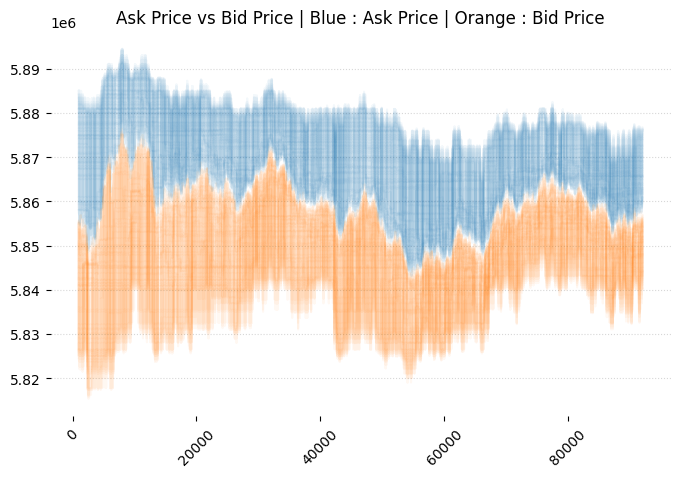

In [6]:
fig, ax = plt.subplots(figsize = (8, 5))
for i in range(1, 51) :
    aapl_order_book[f'ask price {i}'].iloc[1000:].plot(color = 'tab:blue', alpha = 0.05)
for i in range(1, 51) :
    aapl_order_book[f'bid price {i}'].iloc[1000:].plot(color = 'tab:orange', alpha = 0.05)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Ask Price vs Bid Price | Blue : Ask Price | Orange : Bid Price')
plt.show()

#### Cancellation Rates, Limit Orders, Market Orders

Eisler et al. (2012) studied the impact of market orders, limit orders, and quote cancellations. The authors found that small-cap and large-cap stocks respond differently to these events. They concluded that modeling these sizes is related to the dynamic modeling of bid-ask spreads.

Easley et al. (2012) also argued that high quote cancellation rates could signal low liquidity, as participants are posting quotes they don't want to be executed. They discuss four categories of predatory algorithms:

- Quote stuffers: These engage in latency arbitrage. Their strategy involves flooding the exchange with messages with the sole intention of slowing down competing algorithms. Since only the message issuer knows which messages can be ignored, others must analyze all messages.

- Quote danglers: This strategy sends quotes that force squeezed traders to follow prices against their own interests. Ohara (2011) provides evidence of this disruptive behavior.

- Liquidity squeezers: When large investors suffering significant losses try to unwind their positions, predatory algorithms trade in the same direction to maximize liquidity depletion. As a result, prices spike and they profit (Carlin, 2007).

- Pack hunters: Independent predators form groups to maximize opportunities by noticing each other's actions and triggering chain reactions (Donefer, 2010; Fabozzi, 2011; Jarrow & Protter, 2011). NANEX (2011) shows groups suspected to be pack hunters forcing stop-losses. Although their individual actions are too small to raise regulatory suspicion, their collective actions can manipulate markets. Even if true, proving collusion is extremely difficult as they cooperate spontaneously in a decentralized manner.

These predatory algorithms use various order types, including quote cancellations, to adverse select market makers. Since they leave multiple traces in trading records, measuring quote cancellations, limit orders, and market orders can provide useful features containing information about their intentions.

#### Time-Weighted Average Price Execution Algorithms

Easley (2012) et al. explained how to recognize the existence of execution algorithms targeting specific Time Weighted Average Price (TWAP). The $TWAP$ algorithm attempts to achieve a predefined $TWAP$ by splitting large orders into smaller ones and submitting them at regular time intervals. The authors selected E-mini S&P500 futures trades between November 7, 2010 and November 7, 2011 as their sample. They divided a day into 24 hours and aggregated the trading volume per second for each hour regardless of minutes. Then they visualized this aggregated trading volume as a surface in a space where the X-axis represents trading volume per second, Y-axis represents intraday time, and Z-axis represents aggregated trading volume. This analysis shows the distribution of trading volume per minute as dates progress, allowing us to locate large order executions by low-frequency investors in chronological order within the time-space. The maximum concentrated trading volume within 1 minute tends to occur mostly in the first few seconds of each hour throughout the day. This is particularly true during 00:00-01:00 GMT (Asian market opening), 05:00-09:00 (UK and European market opening), 13:00-15:00 (US market opening), and 20:00-21:00 (US market closing).

A useful Machine Learning feature is to evaluate order imbalance at the start of each minute and determine if there is a consistent component. When a large portion of $TWAP$ orders from institutional investors is pending, this can be used to trade ahead of these large institutional investors.

In [4]:
import time
import datetime

class TWAPExecutor:
    def __init__(self, total_order_size, num_slices, start_time, end_time):
        self.total_order_size = total_order_size
        self.num_slices = num_slices
        self.start_time = start_time
        self.end_time = end_time
        self.slice_size = self.total_order_size / self.num_slices
        self.interval = (self.end_time - self.start_time).total_seconds() / self.num_slices
        self.executed_orders = []

    def execute_order(self, order_size):
        execution_time = datetime.datetime.now()
        print(f"[{execution_time}] Executed order of size: {order_size}")
        self.executed_orders.append({
            'time': execution_time,
            'size': order_size
        })

    def run(self):
        current_time = datetime.datetime.now()
        print(f"TWAP Execution started at {current_time}")
        for i in range(self.num_slices):
            scheduled_time = self.start_time + datetime.timedelta(seconds=self.interval * i)
            sleep_duration = (scheduled_time - datetime.datetime.now()).total_seconds()
            if sleep_duration > 0:
                time.sleep(sleep_duration)
            self.execute_order(self.slice_size)
        print("TWAP Execution completed.")

#### Option Markets

Muravyev (2013) et al. used microstructure information from stocks and options to study discrepancies between the two markets. They identified these discrepancies by deriving the implied bid-ask spread range from put-call parity quotes and comparing it with the actual stock bid-ask spread range. They concluded that discrepancies tend to resolve in favor of stock quotes, suggesting that option quotes do not contain economically significant information. However, they also discovered that option trading contains information not reflected in stock prices. This finding is not particularly surprising for portfolio managers trading relatively illiquid instruments like stock options. Even when sparse prices are informative, quotes can remain irrational for extended periods.

Cremers and Weinbaum (2010) found that stocks with relatively expensive calls outperform those with relatively expensive puts by 50 basis points per month. The degree of this predictability increases when option liquidity is high and stock liquidity is low.

A useful feature consistent with these observations can be extracted by calculating the stock price implied by put-call option trading. While futures prices only represent the mean or expected value of future worth, option prices allow us to derive the entire distribution of outcomes being priced. Machine Learning Algorithms can identify patterns in various indicators calculated across different strike prices and maturities.
End of Selection

In [5]:
put_call = pd.read_excel('./research/Data/put_call_ratio.xlsx', index_col = 0)

In [6]:
import yfinance as yf

aapl_price = yf.download(
    'AAPL',
    start = '2000-01-01',
    end = '2024-09-03',
    progress = False
)

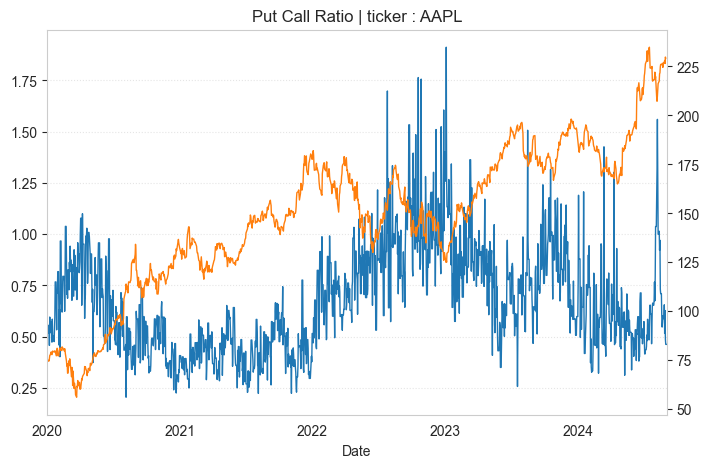

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))

put_call.loc['2020':, 'AAPL'].plot(lw = 1)
aapl_price.loc['2020':, 'Close'].plot(secondary_y = True, lw = 1)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Put Call Ratio | ticker : AAPL')
plt.show()

#### Serial Correlation of Signed Order Flow

Toth (2011) et al. studied the signed order flow of stocks in the London stock market and found that order signs exhibit positive autocorrelation over multiple days. They proposed two candidate explanations for this observation: herding and order splitting. They concluded that the persistence of order flow at time scales of a few hours or less is due to order splitting rather than herding.

If market microstructure explains the persistence of order flow imbalance through the presence of information-based traders, then measuring the strength of this persistence through serial correlation of signed trading volume would be meaningful. This feature would play a complementary role to the features we have examined earlier.